In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import sys

In [3]:
import json
plt_properties = json.load(open('utils/plt_properties.json'))
fig_width = plt_properties['fig_width']
plt.rcParams.update(plt_properties['plt_params'])

In [4]:
sys.path.append(os.path.join(os.getcwd(), 'utils'))
from bland_altman import bland_altman_plot
from correlation import plot_regression, plot_group_differences
from permutation_test import permutation_test_repeated
from variables import target_col, corrected

In [5]:
df = pd.read_csv('../Data/dataset_mlr.csv')

/tmp/ipykernel_12370/900100850.py:1: DtypeWarning: Columns (12,22,23,24,25,35,36,37,38,39,44,48,49,53,54,55,61,72,76,121,122,124,125,127,136,138,139,140,141,142,143,144,152,157,158,159,161,162,163,210,216,218,219,221,233,251,252,254,503,509,511,513,515,519,523,525,527,529) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/dataset_mlr.csv')


# 9) Creatinine correction

## 9.1) Correlation

Many prediction formulas are based on an assumed constant excretion of creatinine.  
Here we analyze the prediction of 24Na excretion when having access to the 24hour creatinine excretion.

Coeffs: [0.65104571]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.6510      0.014     46.784      0.000       0.624       0.678


Text(0, 0.5, '24-hour urinary sodium [mmol]')

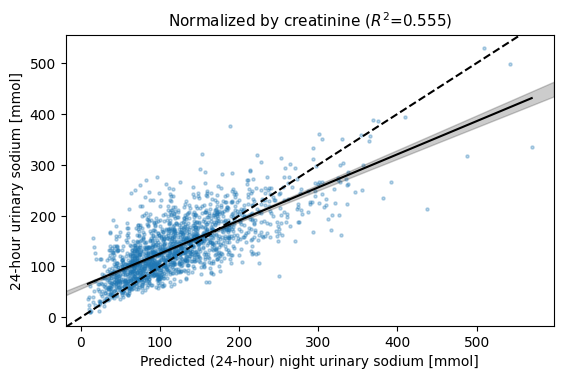

In [6]:
fig, ax = plt.subplots(figsize=(fig_width, 0.6 * fig_width))

x = df.una_un_mmol * (df[f"ucrt_u24{'corr' if corrected else ''}_umol"] / df.ucrt_un_umol)
y = df[target_col]
id_col = df['sk1_id']
r_squared = plot_regression(x, y, ax)
ax.set_title(f'Normalized by creatinine ($R^2$={round(r_squared, 4)})')
ax.set_xlabel('Predicted (24-hour) night urinary sodium [mmol]')
ax.set_ylabel('24-hour urinary sodium [mmol]')

## 9.2) Distributions

In [7]:
def mean(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def mean_perm_test_repeated(x, y, x_id, y_id):
    return permutation_test_repeated(
        x, y, x_id, y_id, mean, n_resamples=1e4, permutation_type='samples', alternative='two-sided', random_state=42
    ).pvalue

print(f'Significant difference mean: ({round(y.mean(), 1)} vs {round(x.mean(), 1)})',
      round(mean_perm_test_repeated(x, y, df['sk1_id'], df['sk1_id']), 4))

def median(x, y, axis=None):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

def median_perm_test_repeated(x, y, x_id, y_id):
    return permutation_test_repeated(
        x, y, x_id, y_id, median, n_resamples=1e4, permutation_type='samples', alternative='two-sided', random_state=42
    ).pvalue

print(f'Significant difference median: ({round(y.median(), 1)} vs {round(x.median(), 1)})',
      round(median_perm_test_repeated(x, y, df['sk1_id'], df['sk1_id']), 4))

def std(x, y, axis=None):
    return np.std(x, axis=axis) - np.std(y, axis=axis)

def std_perm_test_repeated(x, y, x_id, y_id):
    return permutation_test_repeated(
        x, y, x_id, y_id, std, n_resamples=1e4, permutation_type='samples', alternative='two-sided', random_state=42
    ).pvalue

print(f'Significant difference median: ({round(y.std(), 1)} vs {round(x.std(), 1)})',
      round(std_perm_test_repeated(x, y, df['sk1_id'], df['sk1_id']), 4))

/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/scipy/stats/_resampling.py:840: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


Significant difference mean: (140.2 vs 122.7) 0.0002


/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/scipy/stats/_resampling.py:840: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


Significant difference median: (131.9 vs 111.2) 0.0002
Significant difference median: (59.8 vs 68.4) 0.0002


In [8]:
rmse_creatinine = np.mean((y - x) ** 2) ** 0.5
rmse_creatinine

49.62051335649738

## 9.3) Bland-Altman plot

R[write to console]: Loading required package: nlme



[1] "CAUTION! Parametric bootstrap implementation differs from Parker et al. This feature should be considered experimental."
[1] "Running bootstrap; this could take a while..."
================================================================================p-value no correlation x-y: 0.00019998000199980003.


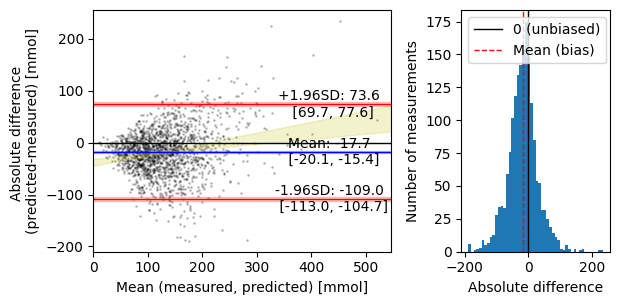

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(fig_width, 0.5 * fig_width), gridspec_kw={'width_ratios': [2, 1]})
diff = bland_altman_plot(y, x, id_col, ax=ax[0])
ax[1].hist(diff, bins=50)
ax[1].axvline(0, c='k', linewidth=1, label='0 (unbiased)')
ax[1].axvline(np.mean(diff), c='r', linewidth=1, linestyle='--', label='Mean (bias)')
ax[1].set_xlabel('Absolute difference')
ax[1].set_ylabel('Number of measurements')
ax[1].legend(loc='upper left')
fig.tight_layout()

[1] "CAUTION! Parametric bootstrap implementation differs from Parker et al. This feature should be considered experimental."
[1] "Running bootstrap; this could take a while..."
================================================================================p-value no correlation x-y: 0.00019998000199980003.


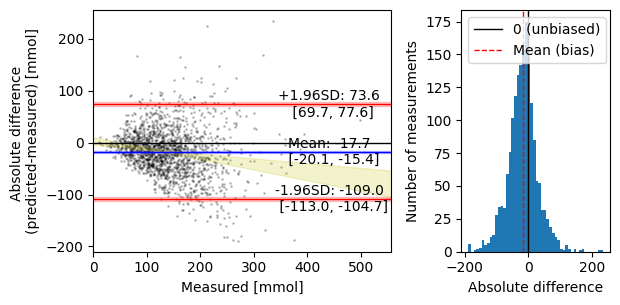

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(fig_width, 0.5 * fig_width), gridspec_kw={'width_ratios': [2, 1]})
diff = bland_altman_plot(y, x, id_col, ax=ax[0], x_true=True)
ax[1].hist(diff, bins=50)
ax[1].axvline(0, c='k', linewidth=1, label='0 (unbiased)')
ax[1].axvline(np.mean(diff), c='r', linewidth=1, linestyle='--', label='Mean (bias)')
ax[1].set_xlabel('Absolute difference')
ax[1].set_ylabel('Number of measurements')
ax[1].legend(loc='upper left')
fig.tight_layout()

## 9.4) Prediction of creatinine

Used i.p. to evaluate completeness.

In [11]:
df_sub = df[(~df['bwi'].isna()) * (~df['age'].isna()) * (~df['sex'].isna()) * (~df['bmi'].isna())]

In [12]:
def creatinine_pred(r):
    pred_umol_kg = 266.16
    if r['sex'] == 'Female':
        pred_umol_kg -= 47.71
    pred_umol_kg += -2.33 * r['bmi'] + 0.66 * r['age'] - 0.017 * (r['age'] ** 2)
    pred_umol = pred_umol_kg * r['bwi']
    return pred_umol


meas_creatinine = df_sub['ucrt_u24corr_umol']
pred_creatinine = df_sub.apply(creatinine_pred, axis=1)

Coeffs: [0.64897586]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.6490      0.013     48.619      0.000       0.623       0.675


[Text(0.5, 0, 'Measured 24-hour creatinine excretions [umol]'),
 Text(0, 0.5, 'Predicted 24-hour creatinine excretions [umol]'),
 Text(0.5, 1.0, 'Predicted vs measured 24-hour creatinine excretions \n($R^2$=0.5745)')]

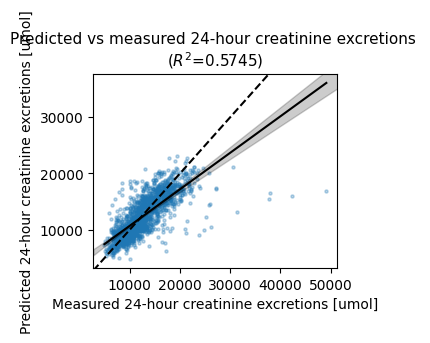

In [13]:
fig, ax = plt.subplots(figsize=(0.5 * fig_width, 0.4 * fig_width))
r_squared = plot_regression(meas_creatinine, pred_creatinine, ax)
ax.set(xlabel='Measured 24-hour creatinine excretions [umol]', ylabel='Predicted 24-hour creatinine excretions [umol]',
        title=f'Predicted vs measured 24-hour creatinine excretions \n($R^2$={round(r_squared, 4)})')

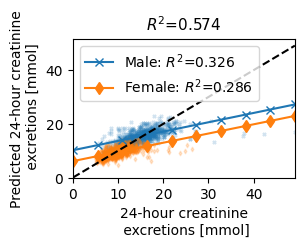

In [14]:
fig, ax = plt.subplots(figsize=(0.5 * fig_width, 0.4 * fig_width))
plot_group_differences(meas_creatinine / 1000, pred_creatinine / 1000, df_sub['sex'], ax, show_id=True)
ax.set(xlabel='24-hour creatinine\n excretions [mmol]', ylabel='Predicted 24-hour creatinine\n excretions [mmol]',
      title=f'$R^2$={round(r_squared, 3)}')
fig.tight_layout()
fig.savefig('../Figures/eda/creatinine_check.png', dpi=500)